In [14]:
using Revise
using PseudoArcLengthContinuation, LinearAlgebra, Plots, SparseArrays;
const Cont = PseudoArcLengthContinuation


PseudoArcLengthContinuation

In [15]:
f1(u, v) = u^2*v

function F_bru(x, α, β; D1 = 0.008, D2 = 0.004, l = 1.0)
	n = div(length(x), 2)
	h = 1.0 / (n+1); h2 = h*h

	u = @view x[1:n]
	v = @view x[n+1:2n]

	# output
	f = similar(x)

	f[1] = u[1] - α
	f[n] = u[n] - α
	for i=2:n-1
		f[i] = D1/l^2 * (u[i-1] - 2u[i] + u[i+1]) / h2 - (β + 1) * u[i] + α + f1(u[i], v[i])
	end


	f[n+1] = v[1] - β / α
	f[end] = v[n] - β / α;
	for i=2:n-1
		f[n+i] = D2/l^2 * (v[i-1] - 2v[i] + v[i+1]) / h2 + β * u[i] - f1(u[i], v[i])
	end

	return f
end

function Jac_mat(x, α, β; D1 = 0.008, D2 = 0.004, l = 1.0)
	n = div(length(x), 2)
	h = 1.0 / (n+1); hh = h*h

	J = zeros(2n, 2n)

	J[1, 1] = 1.0
	for i=2:n-1
		J[i, i-1] = D1 / hh/l^2
		J[i, i]   = -2D1 / hh/l^2 - (β + 1) + 2x[i] * x[i+n]
		J[i, i+1] = D1 / hh/l^2
		J[i, i+n] = x[i]^2
	end
	J[n, n] = 1.0

	J[n+1, n+1] = 1.0
	for i=n+2:2n-1
		J[i, i-n] = β - 2x[i-n] * x[i]
		J[i, i-1] = D2 / hh/l^2
		J[i, i]   = -2D2 / hh/l^2 - x[i-n]^2
		J[i, i+1] = D2 / hh/l^2
	end
	J[2n, 2n] = 1.0
	return J
end

function Jac_sp(x, α, β; D1 = 0.008, D2 = 0.004, l = 1.0)
	# compute the Jacobian using a sparse representation
	n = div(length(x), 2)
	h = 1.0 / (n+1); hh = h*h

	diag  = zeros(2n)
	diagp1 = zeros(2n-1)
	diagm1 = zeros(2n-1)

	diagpn = zeros(n)
	diagmn = zeros(n)

	diag[1] = 1.0
	diag[n] = 1.0
	diag[n + 1] = 1.0
	diag[end] = 1.0

	for i=2:n-1
		diagm1[i-1] = D1 / hh/l^2
		diag[i]   = -2D1 / hh/l^2 - (β + 1) + 2x[i] * x[i+n]
		diagp1[i] = D1 / hh/l^2
		diagpn[i] = x[i]^2
	end

	for i=n+2:2n-1
		diagmn[i-n] = β - 2x[i-n] * x[i]
		diagm1[i-1] = D2 / hh/l^2
		diag[i]   = -2D2 / hh/l^2 - x[i-n]^2
		diagp1[i] = D2 / hh/l^2
	end
	return spdiagm(0 => diag, 1 => diagp1, -1 => diagm1, n => diagpn, -n => diagmn)
end



function finalise_solution(z, tau, step, contResult)
	n = div(length(z), 2)
	printstyled(color=:red, "--> Solution constante = ", norm(diff(z[1:n])), " - ", norm(diff(z[n+1:2n])), "\n")
end

finalise_solution (generic function with 1 method)

In [16]:
n = 101
# const Δ = spdiagm(0=>2ones(N), -1=>0ones(N-1), 1=>-ones(N-1))
Jac_fd(u0, α, β, l = l) = Cont.finiteDifferences(u->F_bru(u, α, β, l=l), u0)

a = 2.
b = 5.45
sol0 = vcat(a*ones(n), b/a*ones(n))

opt_newton = Cont.NewtonPar(tol = 1e-11, verbose = true)
	# ca fait dans les 60.2k Allocations
	out, hist, flag = @time Cont.newton(
		x -> F_bru(x, a, b),
		x -> Jac_mat(x, a, b),
		sol0,
		opt_newton)


 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     0.0000e+00         0
  0.137356 seconds (406.39 k allocations: 19.447 MiB, 7.24% gc time)


([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725], [0.0], true, 0)

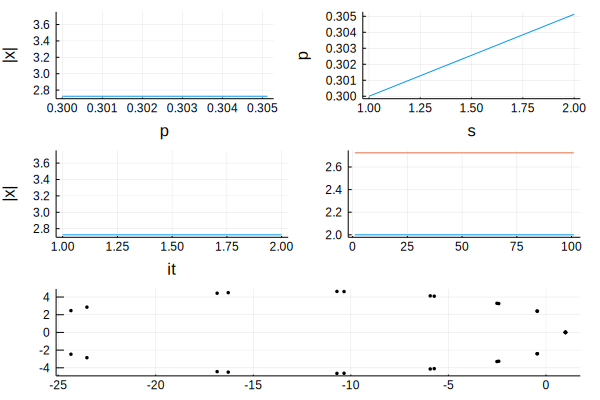

--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constan

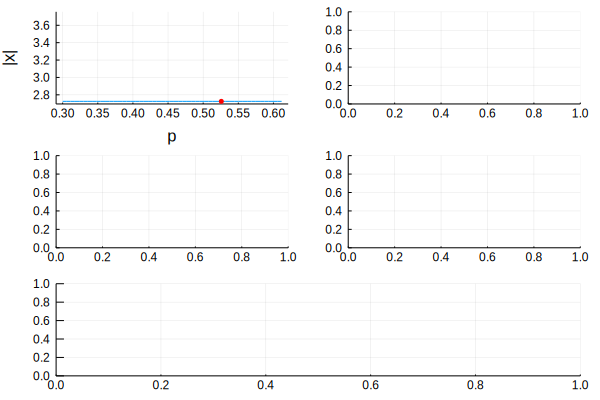

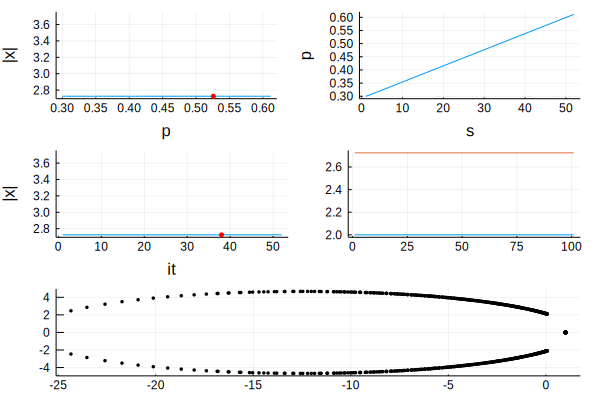

--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constan

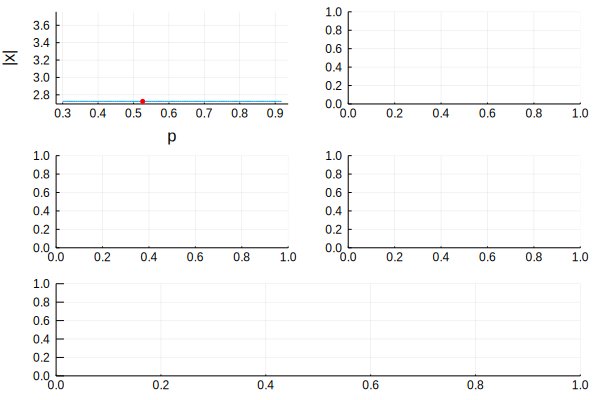

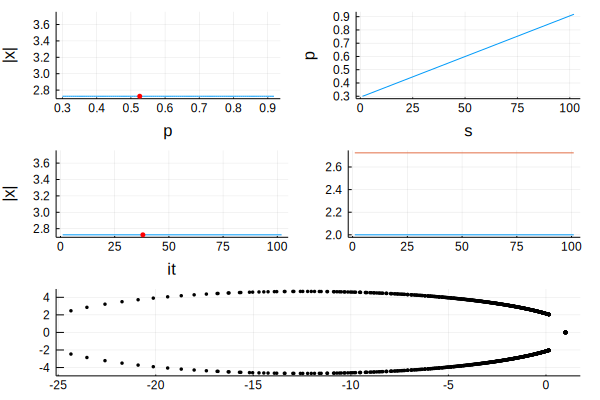

--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0


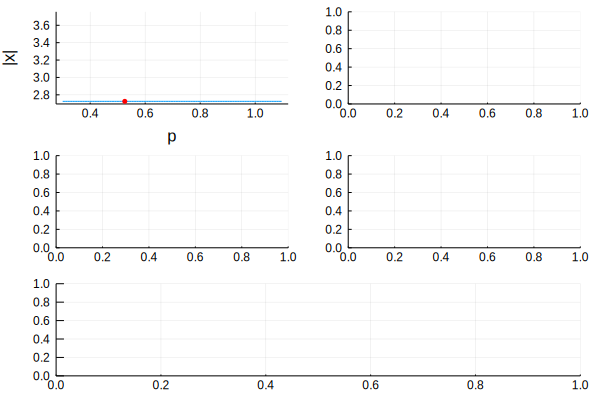

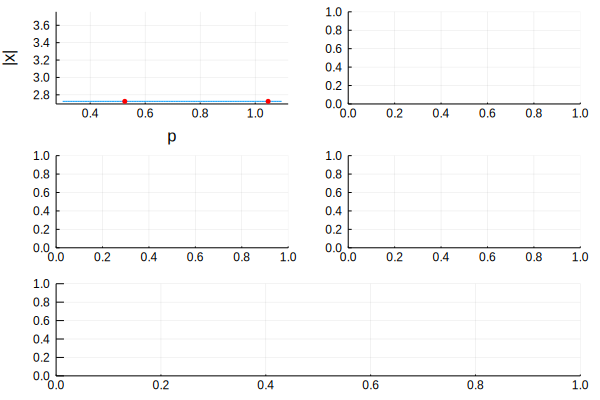

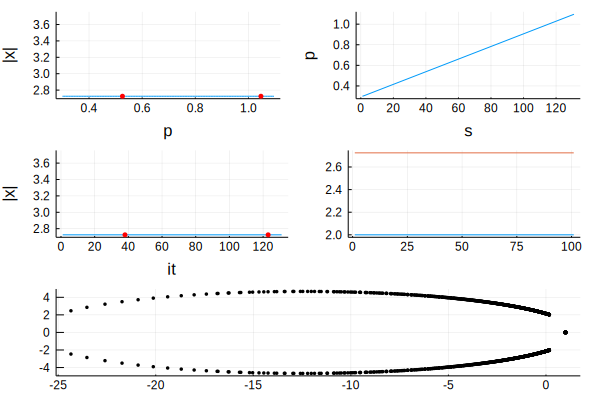

--> Solution constante = 0.0 - 0.0
--> Solution constante = 0.0 - 0.0
  6.448177 seconds (12.56 M allocations: 702.959 MiB, 2.79% gc time)


(PseudoArcLengthContinuation.ContResult{Float64,Array{Float64,1},Array{Complex{Float64},2}}
  branch: RecursiveArrayTools.VectorOfArray{Float64,2,Array{Array{Float64,1},1}}
  eig: Array{Tuple{Array{Complex{Float64},1},Array{Complex{Float64},2},Int64}}((131,))
  bifpoint: Array{Tuple{Symbol,Int64,Float64,Float64,Array{Float64,1},Array{Float64,1},Int64}}((2,))
  stability: Array{Bool}((131,)) Bool[false, false, false, false, false, false, false, false, false, false  …  false, false, false, false, false, false, false, false, false, false]
  n_imag: Array{Int64}((131,)) [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  2, 2, 4, 4, 4, 4, 4, 4, 4, 4]
  n_unstable: Array{Int64}((131,)) [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  6, 6, 8, 8, 8, 8, 8, 8, 8, 8]
, PseudoArcLengthContinuation.BorderedVector{Array{Float64,1},Float64}([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725, 2.725], 1.0959899496852972), PseudoArcLengthContinuation.BorderedVector{Arra

In [17]:
opts_br0 = ContinuationPar(dsmin = 0.001, dsmax = 0.0061, ds= 0.0051, pMax = 1.2, save = false, theta = 0.01, detect_fold = true, detect_bifurcation = true, nev = 16, plot_every_n_steps = 50)
	opts_br0.newtonOptions.maxIter = 20
	opts_br0.newtonOptions.tol = 1e-8
	opts_br0.maxSteps = 130

	br, u1 = @time Cont.continuation(
		(x, p) ->   F_bru(x, a, b, l = p),
		(x, p) -> Jac_mat(x, a, b, l = p),
		out,
		0.3,
		opts_br0,
		plot = true,
		plotsolution = (x;kwargs...)->(N = div(length(x), 2);plot!(x[1:N], subplot=4, label="");plot!(x[N+1:2N], subplot=4, label="")),
		finaliseSolution = finalise_solution,
		printsolution = x->norm(x, Inf64), verbosity = 0)


On affine la bifurcation de Hopf trouvee dans la cellule precedente

In [20]:
ind_hopf = 1
	hopfpt = Cont.HopfPoint(br, ind_hopf)

	outhopf, hist, flag = @time Cont.newtonHopf((x, p) ->  F_bru(x, a, b, l = p),
                (x, p) -> Jac_mat(x, a, b, l = p),
				br, ind_hopf,
				NewtonPar(verbose = true))
	flag && printstyled(color=:red, "--> We found a Hopf Point at l = ", outhopf[end-1], ", ω = ", outhopf[end], " from ",hopfpt[end-1] ,"\n")


--> Newton Hopf, the eigenvalue considered here is 0.0021967094536775172 - 2.138088375397315im

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     2.4633e-03         0
        1                2     2.2351e-05         2
        2                3     1.4071e-09         2
        3                4     3.3500e-14         2
  0.456584 seconds (312.23 k allocations: 431.424 MiB, 19.50% gc time)
--> We found a Hopf Point at l = 0.5232588119304792, ω = 2.1395092895335197 from 0.5258319970887445


┌ Warning: Bad way it creates a struct for every p2
└ @ PseudoArcLengthContinuation /Users/rveltz/work/prog_gd/julia/dev/PseudoArcLengthContinuation/src/HopfCont.jl:185


##################################################
*********** ArcLengthContinuationNewton *************

*********** CONVERGE INITIAL GUESS *************
 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     2.4633e-03         0
        1                2     2.2351e-05         2
        2                3     1.4071e-09         2
        3                4     3.3500e-14         2

--> convergence of initial guess = OK
--> p = 5.45, initial step

*********** COMPUTING TANGENTS *************
 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     5.6314e-03         0
        1                2     4.5770e-08         2
        2                3     4.4247e-14         2

--> convergence of initial guess = OK

--> p = 5.450200000000001, initial step (bis)
--> Start continuation from p = 5.45
########################################################################
Start

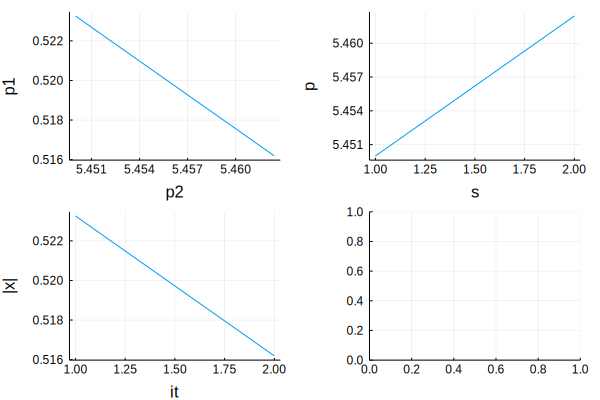

        2                1     1.2232e-13 (     2,      2)
--> Step Converged in 2 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.8432
########################################################################
Start of Continuation Step 1 : Parameter: p1 = 5.4977e+00 from 5.4624e+00
Current step size  = 2.8432e-02   Previous step size = 1.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     1.6152e-02         0
        1                1     5.8455e-06 (     2,      2)
        2                1     9.5414e-11 (     2,      2)
--> Step Converged in 2 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.8432
########################################################################
Start of Continuation Step 2 : Parameter: p1 = 5.5597e+00 from 5.4977e+00
Current step size  = 5.0000e-02   Previous step size = 1.0000e-02

 Newton Iterations 
   Iterat

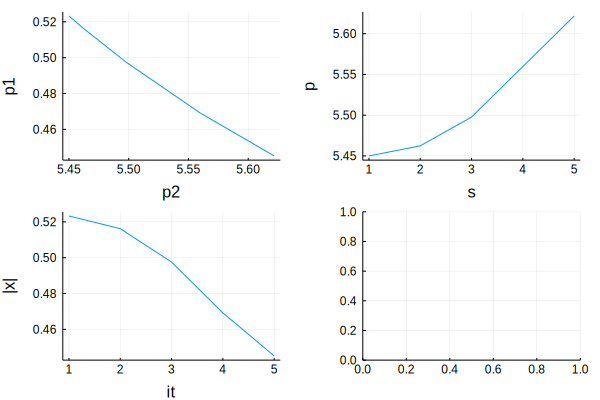

       3                1     1.1325e-13 (     2,      2)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.7672
########################################################################
Start of Continuation Step 4 : Parameter: p1 = 5.6837e+00 from 5.6217e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     7.1007e-03         0
        1                1     8.9484e-05 (     2,      2)
        2                1     1.4378e-08 (     2,      2)
        3                1     9.0362e-14 (     2,      2)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.7672
########################################################################
Start of Continuation Step 5 : Parameter: p1 = 5.7458e+00 from 5.6837e+00
Current step size  = 5.0000e-02   Prev

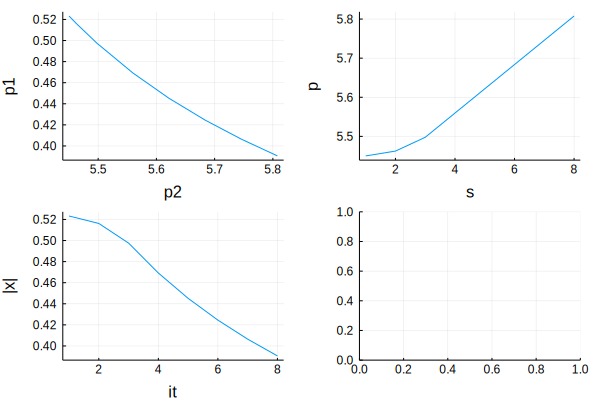

       3                1     1.4672e-13 (     2,      2)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.7672
########################################################################
Start of Continuation Step 7 : Parameter: p1 = 5.8698e+00 from 5.8078e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     5.2141e-03         0
        1                1     3.9305e-05 (     2,      2)
        2                1     2.2842e-09 (     2,      2)
        3                1     7.3495e-14 (     2,      2)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.7672
########################################################################
Start of Continuation Step 8 : Parameter: p1 = 5.9318e+00 from 5.8698e+00
Current step size  = 5.0000e-02   Prev

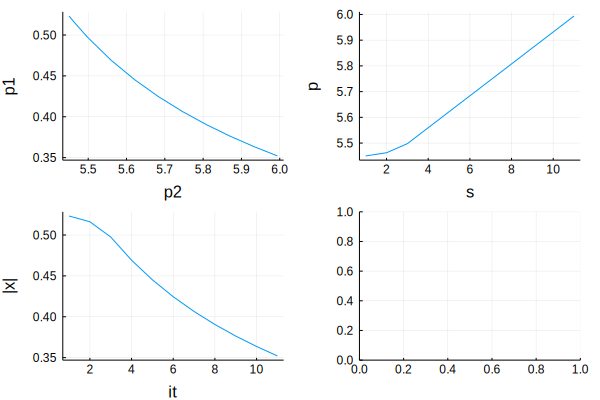

       3                1     3.0834e-13 (     2,      2)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.7672
########################################################################
Start of Continuation Step 10 : Parameter: p1 = 6.0559e+00 from 5.9939e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     4.1078e-03         0
        1                1     2.0648e-05 (     2,      2)
        2                1     5.2915e-10 (     2,      2)
        3                1     2.2080e-13 (     2,      2)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.7672
########################################################################
Start of Continuation Step 11 : Parameter: p1 = 6.1179e+00 from 6.0559e+00
Current step size  = 5.0000e-02   Pr

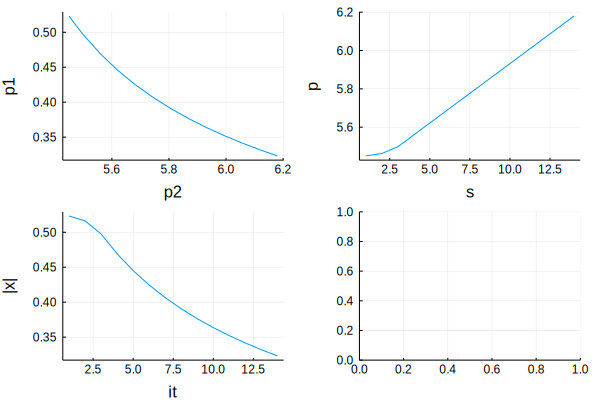

       3                1     1.7098e-13 (     2,      2)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.7672
########################################################################
Start of Continuation Step 13 : Parameter: p1 = 6.2420e+00 from 6.1800e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     3.3809e-03         0
        1                1     1.2158e-05 (     2,      2)
        2                1     1.8833e-10 (     2,      2)
        3                1     7.2971e-14 (     2,      2)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.7672
########################################################################
Start of Continuation Step 14 : Parameter: p1 = 6.3041e+00 from 6.2420e+00
Current step size  = 5.0000e-02   Pr

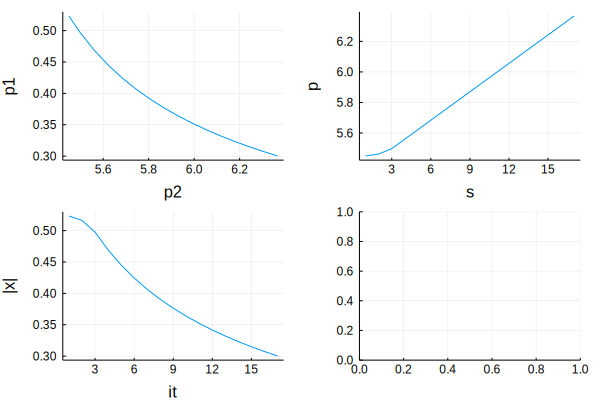

        2                1     6.0666e-11 (     2,      2)
--> Step Converged in 2 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.8432
########################################################################
Start of Continuation Step 16 : Parameter: p1 = 6.4281e+00 from 6.3661e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     2.8669e-03         0
        1                1     7.7498e-06 (     2,      2)
        2                1     6.7650e-11 (     2,      2)
--> Step Converged in 2 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.8432
########################################################################
Start of Continuation Step 17 : Parameter: p1 = 6.4902e+00 from 6.4281e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iter

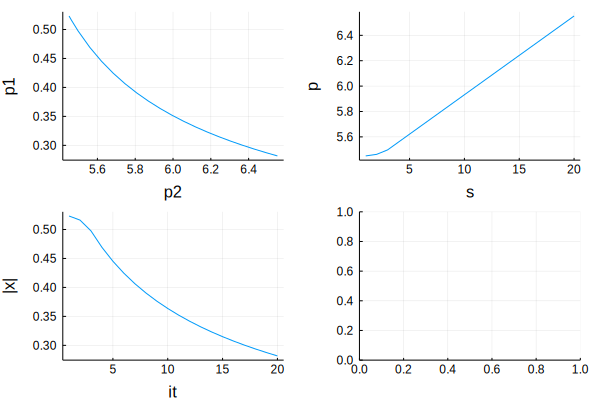

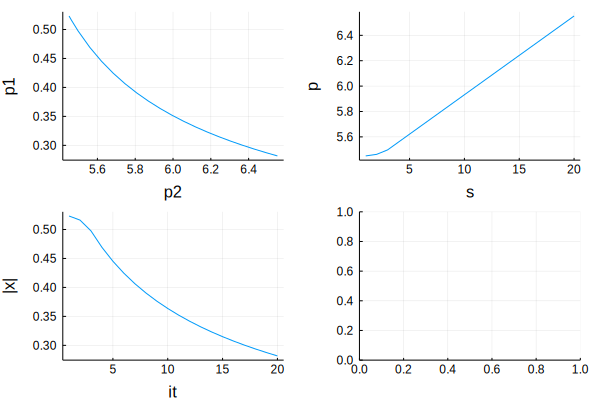

       2                1     2.2932e-11 (     2,      2)
--> Step Converged in 2 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 2.8432
 14.569767 seconds (9.82 M allocations: 14.934 GiB, 18.78% gc time)


(PseudoArcLengthContinuation.ContResult{Float64,Array{Float64,1},Array{Complex{Float64},2}}
  branch: RecursiveArrayTools.VectorOfArray{Float64,2,Array{Array{Float64,1},1}}
  eig: Array{Tuple{Array{Complex{Float64},1},Array{Complex{Float64},2},Int64}}((1,))
  bifpoint: Array{Tuple{Symbol,Int64,Float64,Float64,Array{Float64,1},Array{Float64,1},Int64}}((0,))
  stability: Array{Bool}((1,)) Bool[false]
  n_imag: Array{Int64}((1,)) [0]
  n_unstable: Array{Int64}((1,)) [0]
, PseudoArcLengthContinuation.BorderedVector{Array{Float64,1},Float64}([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  3.2761, 3.2761, 3.2761, 3.2761, 3.2761, 3.2761, 3.2761, 3.2761, 0.281741, 2.40871], 6.552192506676094), PseudoArcLengthContinuation.BorderedVector{Array{Float64,1},Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.620359, 0.620359, 0.620359, 0.620359, 0.620359, 0.620359, 0.620359, 0.620359, -0.116094, 0.257022], 1.2407185524290318))

In [23]:
br_hopf, u1_hopf = @time Cont.continuationHopf(
			(x, p, β) ->   F_bru(x, a, β, l = p),
			(x, p, β) -> Jac_mat(x, a, β, l = p),
			br, ind_hopf,
			b,
			ContinuationPar(dsmin = 0.001, dsmax = 0.05, ds= 0.01, pMax = 6.5, pMin = 0.0, a = 2., theta = 0.4, newtonOptions = NewtonPar(verbose=true)))

On essaie de trouver une orbite periodique proche de la bifurcation de Hopf

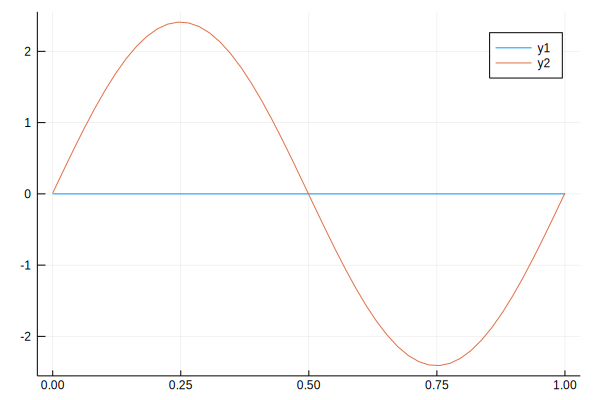

In [35]:
function plotPeriodic(outpof,n,M)
	outpo = reshape(outpof[1:end-1], 2n, M)
	plot(heatmap(outpo[1:n,:], ylabel="Time"),
			heatmap(outpo[n+2:end,:]))
end

ind_hopf = 1
hopfpt = Cont.HopfPoint(br, ind_hopf)

l_hopf = hopfpt[end-1]
ωH     = hopfpt[end] |> abs
M = 50


orbitguess = zeros(2n, M)
plot([0, 1], [0, 0])
	phase = []; scalphase = []
	vec_hopf = br.eig[br.bifpoint[ind_hopf][2]][2][:, br.bifpoint[ind_hopf][end]-1]
	for ii=1:M
	t = (ii-1)/(M-1)
	orbitguess[:, ii] .= real.(hopfpt[1:2n] +
						26*0.1 * vec_hopf * exp(2pi * complex(0, 1) * (t - 0.279))) #k=1
	push!(phase, t);push!(scalphase, dot(orbitguess[:, ii]- hopfpt[1:2n], real.(vec_hopf)))
end
	plot!(phase, scalphase) |> display
orbitguess_f = vcat(vec(orbitguess), 2pi/ωH) |> vec;

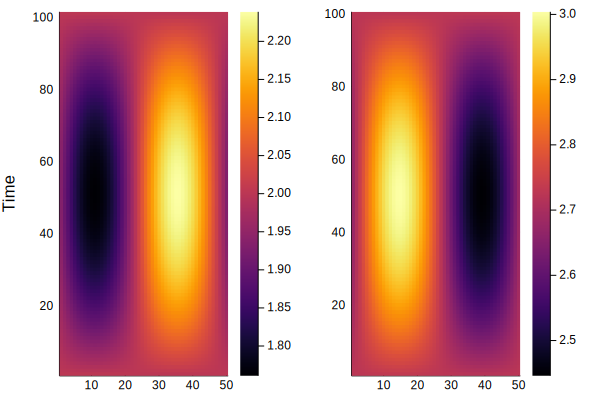

In [36]:
plot(heatmap(orbitguess[1:n,:], ylabel="Time"),heatmap(orbitguess[n+2:end,:]))


 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     2.3832e-01         0
        1                2     6.2039e-03         1
        2                3     2.3989e-02         1
        3                4     1.9345e-03         1
        4                5     4.2416e-05         1
        5                6     1.6252e-08         1
        6                7     2.5161e-13         1
 16.885581 seconds (155.59 k allocations: 4.864 GiB, 5.55% gc time)
--> T = 3.025391601509498


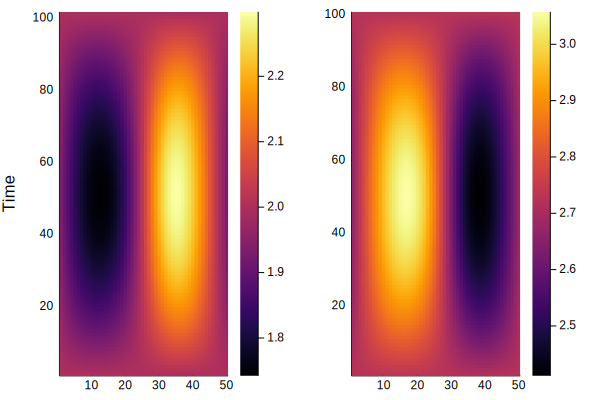

In [37]:
opt_po = Cont.NewtonPar(tol = 1e-8, verbose = true, maxIter = 50)
	outpo_f, hist, flag = @time Cont.newton(
						x ->  poTrap(l_hopf + 0.01)(x),
						x ->  poTrap(l_hopf + 0.01)(x, :jacsparse),
						orbitguess_f,
						opt_po)
	println("--> T = ", outpo_f[end])
	plotPeriodic(outpo_f,n,M)

##################################################
*********** ArcLengthContinuationNewton *************

*********** CONVERGE INITIAL GUESS *************
 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     2.5161e-13         0

--> convergence of initial guess = OK
--> p = 0.5358319970887445, initial step

*********** COMPUTING TANGENTS *************
 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     1.4668e-05         0
        1                2     2.1042e-07         1
        2                3     3.6092e-13         1

--> convergence of initial guess = OK

--> p = 0.5358519970887445, initial step (bis)
--> Start continuation from p = 0.5358319970887445
########################################################################
Start of Continuation Step 0 : Parameter: p1 = 5.3632e-01 from 5.3583e-01

 Newton Iterations 
   Iterations      Func-count      f(

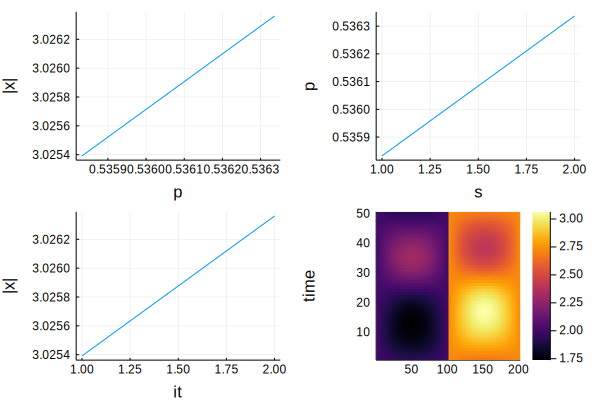

        2                1     2.4664e-13 (     1,      1)
--> Step Converged in 2 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4607999999999999
########################################################################
Start of Continuation Step 1 : Parameter: p1 = 5.3707e-01 from 5.3634e-01
Current step size  = 1.4608e-03   Previous step size = 1.0000e-03

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     4.3265e-04         0
        1                1     2.0301e-08 (     1,      1)
        2                1     2.5308e-13 (     1,      1)
--> Step Converged in 2 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4607999999999999
########################################################################
Start of Continuation Step 2 : Parameter: p1 = 5.3813e-01 from 5.3706e-01
Current step size  = 2.1339e-03   Previous step size = 1.0000e-03

 Newt

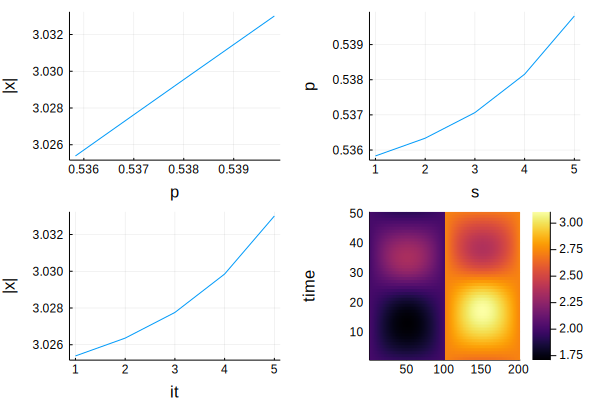

       2                1     4.6547e-13 (     1,      1)
--> Step Converged in 2 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4607999999999999
########################################################################
Start of Continuation Step 4 : Parameter: p1 = 5.4223e-01 from 5.3981e-01
Current step size  = 4.5537e-03   Previous step size = 2.1339e-03

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     4.1522e-03         0
        1                1     1.4031e-06 (     1,      1)
        2                1     5.9161e-12 (     1,      1)
--> Step Converged in 2 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4607999999999999
########################################################################
Start of Continuation Step 5 : Parameter: p1 = 5.4607e-01 from 5.4236e-01
Current step size  = 6.6520e-03   Previous step size = 3.1173e-03

 Newto

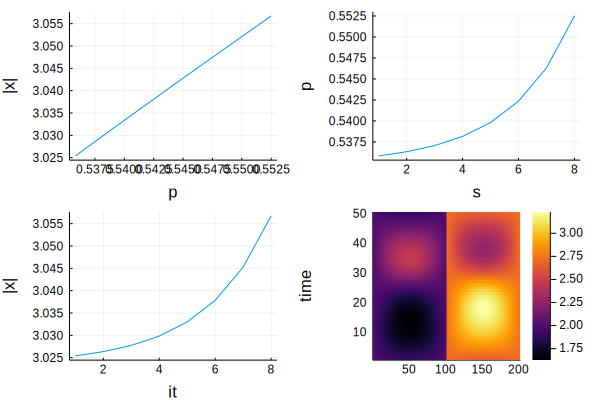

        3                1     2.4044e-13 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 7 : Parameter: p1 = 5.6139e-01 from 5.5250e-01
Current step size  = 1.3828e-02   Previous step size = 6.6520e-03

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     3.4402e-02         0
        1                1     1.0139e-04 (     1,      1)
        2                1     2.7816e-08 (     1,      1)
        3                1     2.3684e-13 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 8 : Parameter: p1 = 5.7628e-01 from 5.6226e-01
Current step size  = 1.9937e-02   Pre

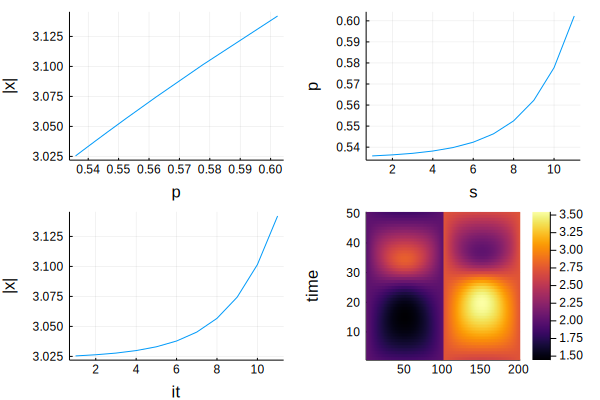

        3                1     1.1244e-11 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 10 : Parameter: p1 = 6.3742e-01 from 6.0230e-01
Current step size  = 4.1446e-02   Previous step size = 1.9937e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     2.0903e-01         0
        1                1     4.0590e-03 (     1,      1)
        2                1     2.4998e-05 (     1,      1)
        3                1     3.7728e-10 (     1,      1)
        4                1     1.7953e-13 (     1,      1)
--> Step Converged in 4 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4232
########################################################################
Start of Continuation Step 11 : Parameter: p1 = 6.8

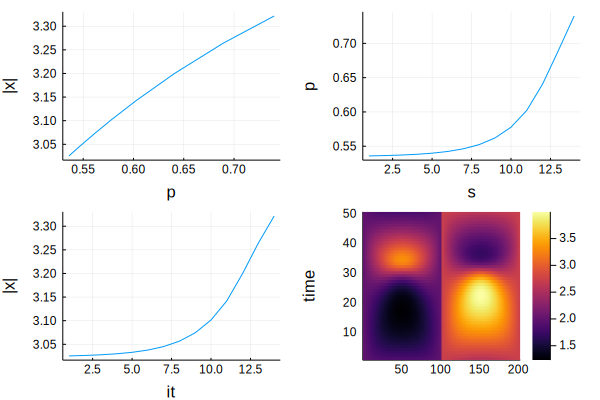

        3                1     9.8377e-11 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 13 : Parameter: p1 = 7.9002e-01 from 7.3990e-01
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     1.2876e-01         0
        1                1     3.2924e-03 (     1,      1)
        2                1     4.4958e-06 (     1,      1)
        3                1     6.1053e-12 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 14 : Parameter: p1 = 8.4210e-01 from 7.9107e-01
Current step size  = 5.0000e-02   P

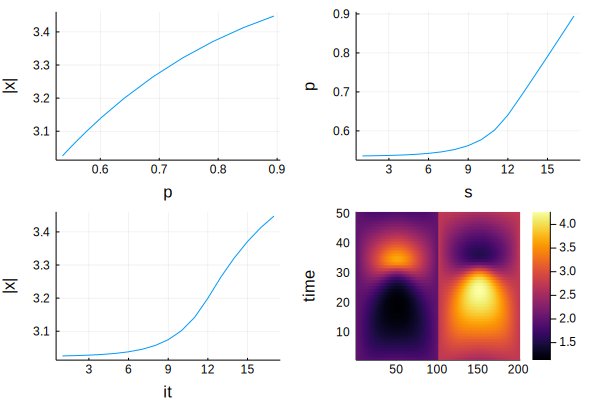

        3                1     1.2538e-13 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 16 : Parameter: p1 = 9.4658e-01 from 8.9468e-01
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     5.4308e-02         0
        1                1     1.3395e-03 (     1,      1)
        2                1     2.5313e-07 (     1,      1)
        3                1     9.4771e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 17 : Parameter: p1 = 9.9891e-01 from 9.4681e-01
Current step size  = 5.0000e-02   P

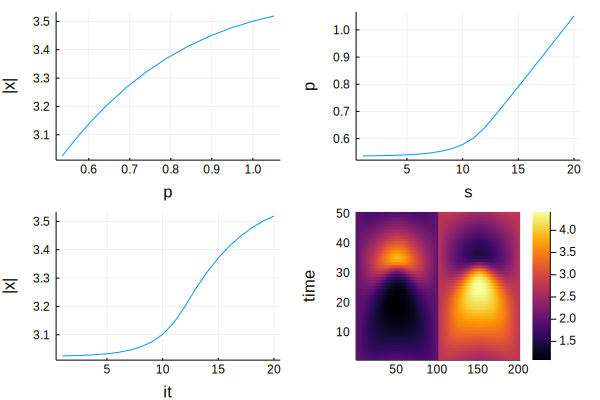

        3                1     7.6920e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 19 : Parameter: p1 = 1.1036e+00 from 1.0513e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     4.4002e-02         0
        1                1     8.6063e-04 (     1,      1)
        2                1     6.2937e-08 (     1,      1)
        3                1     7.2115e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 20 : Parameter: p1 = 1.1559e+00 from 1.1036e+00
Current step size  = 5.0000e-02   P

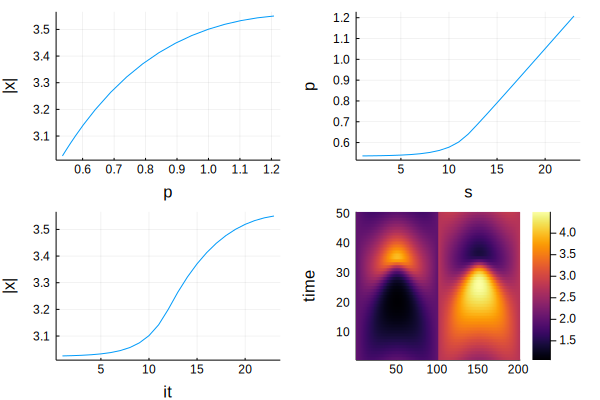

        3                1     6.0266e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 22 : Parameter: p1 = 1.2604e+00 from 1.2082e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     5.1038e-02         0
        1                1     6.7888e-04 (     1,      1)
        2                1     3.1513e-08 (     1,      1)
        3                1     5.5865e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 23 : Parameter: p1 = 1.3126e+00 from 1.2604e+00
Current step size  = 5.0000e-02   P

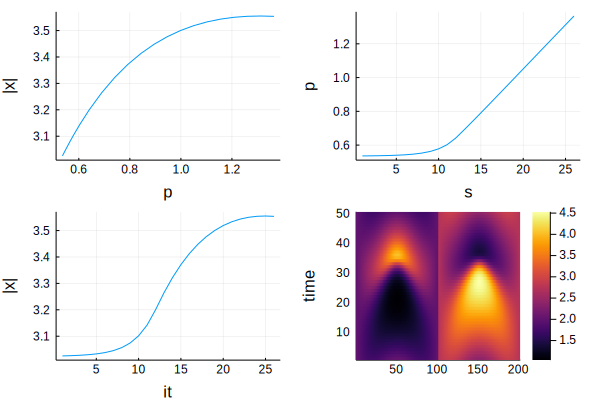

        3                1     4.9735e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 25 : Parameter: p1 = 1.4169e+00 from 1.3647e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     5.9595e-02         0
        1                1     5.2490e-04 (     1,      1)
        2                1     1.8723e-08 (     1,      1)
        3                1     4.6083e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 26 : Parameter: p1 = 1.4689e+00 from 1.4168e+00
Current step size  = 5.0000e-02   P

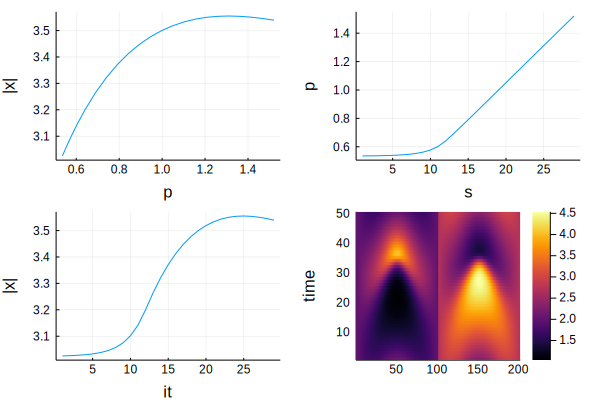

        3                1     4.0595e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 28 : Parameter: p1 = 1.5729e+00 from 1.5209e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     5.9994e-02         0
        1                1     3.3781e-04 (     1,      1)
        2                1     2.1204e-08 (     1,      1)
        3                1     3.8453e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 29 : Parameter: p1 = 1.6249e+00 from 1.5729e+00
Current step size  = 5.0000e-02   P

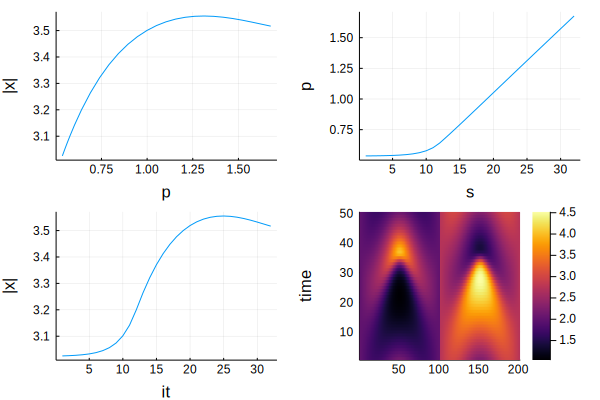

        3                1     3.4444e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 31 : Parameter: p1 = 1.7288e+00 from 1.6768e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     4.4558e-02         0
        1                1     4.6661e-04 (     1,      1)
        2                1     7.3095e-08 (     1,      1)
        3                1     3.3558e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 32 : Parameter: p1 = 1.7808e+00 from 1.7288e+00
Current step size  = 5.0000e-02   P

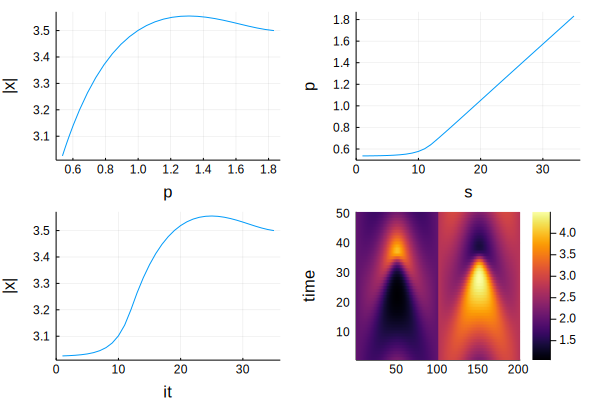

        3                1     3.1204e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 34 : Parameter: p1 = 1.8851e+00 from 1.8330e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     2.2835e-02         0
        1                1     5.2271e-04 (     1,      1)
        2                1     2.0618e-07 (     1,      1)
        3                1     3.0281e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 35 : Parameter: p1 = 1.9374e+00 from 1.8852e+00
Current step size  = 5.0000e-02   P

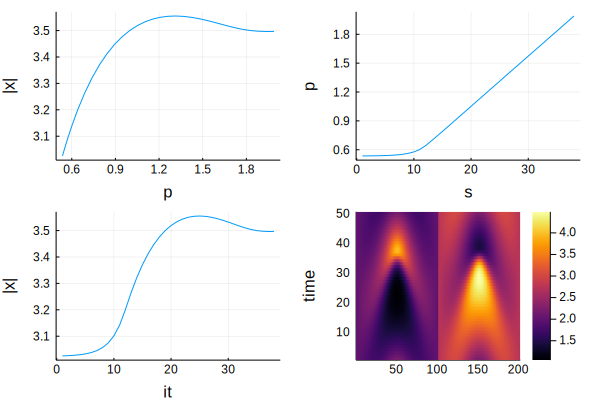

        3                1     2.7875e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 37 : Parameter: p1 = 2.0421e+00 from 1.9898e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     1.2557e-02         0
        1                1     1.2855e-04 (     1,      1)
        2                1     2.6456e-08 (     1,      1)
        3                1     2.6452e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 38 : Parameter: p1 = 2.0946e+00 from 2.0422e+00
Current step size  = 5.0000e-02   P

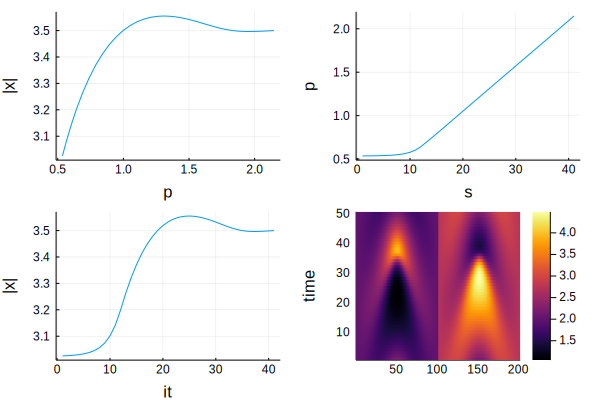

        3                1     2.5643e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 40 : Parameter: p1 = 2.1995e+00 from 2.1471e+00
Current step size  = 5.0000e-02   Previous step size = 5.0000e-02

 Newton Iterations 
   Iterations      Func-count      f(x)      Linear-Iterations

        0                1     8.3184e-03         0
        1                1     4.5269e-05 (     1,      1)
        2                1     3.7183e-09 (     1,      1)
        3                1     2.5156e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
########################################################################
Start of Continuation Step 41 : Parameter: p1 = 2.2520e+00 from 2.1996e+00
Current step size  = 5.0000e-02   P

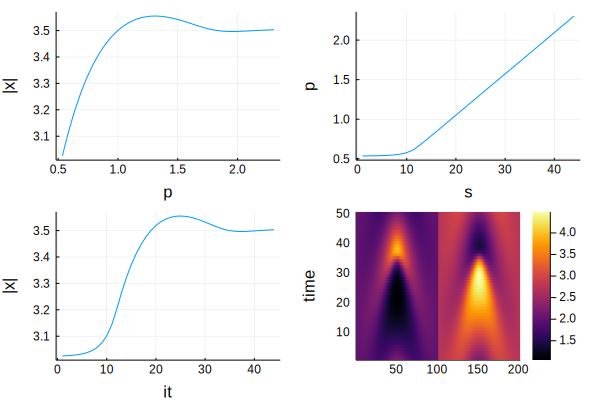

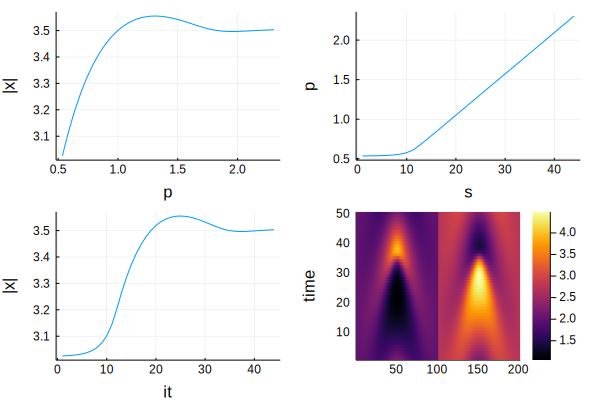

        3                1     2.4307e-14 (     1,      1)
--> Step Converged in 3 Nonlinear Solver Iterations!
--> predictor = Secant
1 + contparams.a * factor ^ 2 = 1.4418
389.917333 seconds (22.41 M allocations: 108.193 GiB, 6.11% gc time)


(PseudoArcLengthContinuation.ContResult{Float64,Array{Float64,1},Array{Complex{Float64},2}}
  branch: RecursiveArrayTools.VectorOfArray{Float64,2,Array{Array{Float64,1},1}}
  eig: Array{Tuple{Array{Complex{Float64},1},Array{Complex{Float64},2},Int64}}((1,))
  bifpoint: Array{Tuple{Symbol,Int64,Float64,Float64,Array{Float64,1},Array{Float64,1},Int64}}((0,))
  stability: Array{Bool}((1,)) Bool[false]
  n_imag: Array{Int64}((1,)) [0]
  n_unstable: Array{Int64}((1,)) [0]
, PseudoArcLengthContinuation.BorderedVector{Array{Float64,1},Float64}([2.0, 2.00029, 2.00036, 2.0, 1.99901, 1.99717, 1.9943, 1.99024, 1.98482, 1.97794  …  2.78597, 2.77513, 2.76544, 2.75684, 2.74921, 2.7424, 2.73623, 2.7305, 2.725, 3.50316], 2.3045827839000226), PseudoArcLengthContinuation.BorderedVector{Array{Float64,1},Float64}([0.0, 0.0291824, 0.0584375, 0.0877567, 0.117053, 0.146157, 0.174815, 0.202687, 0.229348, 0.254295  …  -0.293363, -0.263284, -0.230068, -0.194438, -0.157054, -0.118493, -0.079239, -0.0396611, 0.0,

In [38]:
opts_po_cont = ContinuationPar(dsmin = 0.0001, dsmax = 0.05, ds= 0.001, pMax = 2.3, maxSteps = 400, secant = true, theta=0.1, plot_every_n_steps = 3, newtonOptions = NewtonPar(verbose = true))
	br_pok2, upo , _= @time Cont.continuation(
							(x, p) ->  poTrap(p)(x),
							(x, p) ->  poTrap(p)(x, :jacsparse),
							outpo_f, l_hopf + 0.01,
							opts_po_cont,
							plot = true,
							plotsolution = (x;kwargs...)->heatmap!(reshape(x[1:end-1], 2*n, M)', subplot=4, ylabel="time"),
							printsolution = u -> u[end])